## YOLOv3

In [40]:
# 0) 환경
import os, json, math, random, shutil, zipfile, gc
import copy
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image, ImageOps, ImageEnhance, ImageDraw, ImageFont
from collections import Counter
from sklearn.cluster import KMeans
from google.colab import drive
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from tqdm import tqdm
from PIL import ImageFilter
from sklearn.metrics import classification_report


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('DEVICE =', DEVICE)

DEVICE = cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 1) drawings.zip unzip + 경로 복구
zip_candidates = [Path("/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/art.zip")]
zip_path = None
for c in zip_candidates:
    if c.exists():
        zip_path = c; break
assert zip_path is not None, "drawings.zip을 같은 경로에 업로드하세요."

root = Path("./data")
if root.exists(): shutil.rmtree(root)
root.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(root)

# 원천/라벨 폴더 유추
src_dir = None; lbl_dir = None
for p in root.rglob("*"):
    if p.is_dir() and "원천" in p.name:
        src_dir = p
    if p.is_dir() and "라벨" in p.name:
        lbl_dir = p
if lbl_dir is None:
    # json이 있는 곳을 라벨로
    cand = list(root.rglob("*.json"))
    assert cand, "라벨 JSON을 찾을 수 없습니다."
    lbl_dir = cand[0].parent
if src_dir is None:
    # 이미지 폴더 최상위 추정
    imgs = list(root.rglob("*.jpg")) + list(root.rglob("*.png"))
    assert imgs, "이미지 파일을 찾을 수 없습니다."
    src_dir = imgs[0].parents[2] if len(imgs[0].parents)>=2 else root

print("src_dir:", src_dir)
print("lbl_dir:", lbl_dir)

src_dir: data/Sample/01.원천데이터
lbl_dir: data/Sample/02.라벨링데이터


In [4]:
# 2) JSON 파싱 (경로 복구 강력)
def resolve_img_path(rel_or_name: str):
    p = (lbl_dir / rel_or_name).resolve()
    if p.exists():
        return p
    # 이름으로 전체 검색
    name = Path(rel_or_name).name
    for ext in ["*.jpg"]:
        hits = list(root.rglob(ext))
        hits = [h for h in hits if h.name == name]
        if hits:
            return hits[0]
    # 마지막 시도: 동일 stem
    stem = Path(rel_or_name).stem
    hits = [h for h in root.rglob("*.*") if h.stem == stem and h.suffix.lower() in [".jpg"]]
    if hits:
        return hits[0]
    return None

def parse_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    meta = d.get("meta", {})
    anns = d.get("annotations", {})
    bboxes = anns.get("bbox", [])
    img_rel = meta.get("img_path") or meta.get("image_path") or meta.get("file_path")
    img_path = resolve_img_path(img_rel if img_rel else Path(json_path).with_suffix(".jpg").name)
    return {"img_path": img_path, "bboxes": bboxes}

json_list = sorted(lbl_dir.rglob("*.json"))
items = []
from collections import Counter
label_counter = Counter()

for jp in json_list:
    info = parse_json(jp)
    if info["img_path"] is None or not Path(info["img_path"]).exists():
        continue
    # 표준화: bbox dict: x,y,w,h,label
    fixed = []
    for bb in info["bboxes"]:
        x = float(bb.get("x", bb.get("left", 0)))
        y = float(bb.get("y", bb.get("top", 0)))
        w = float(bb.get("w", bb.get("width", 0)))
        h = float(bb.get("h", bb.get("height", 0)))
        lab = bb.get("label", "unknown")
        if w>0 and h>0:
            fixed.append({"x":x,"y":y,"w":w,"h":h,"label":lab})
            label_counter[lab]+=1
    if fixed:
        items.append({"img_path": info["img_path"], "bboxes": fixed})

assert items, "유효 라벨이 없습니다."
classes = sorted(label_counter.keys())
cls2idx = {c:i for i,c in enumerate(classes)}
idx2cls = {i:c for c,i in cls2idx.items()}
num_classes = len(classes)
print("items:", len(items), "classes:", num_classes)
print("top labels:", label_counter.most_common(10))

items: 560 classes: 47
top labels: [('꽃', 637), ('눈', 560), ('팔', 560), ('발', 560), ('운동화', 560), ('다리', 559), ('귀', 557), ('손', 557), ('잔디', 525), ('주머니', 517)]


In [5]:
# 디렉토리 경로 설정
src_dir = Path("data/Sample/01.원천데이터")  # 원본 이미지 폴더
lbl_dir = Path("data/Sample/02.라벨링데이터")  # 라벨 폴더

# 이미지와 라벨 폴더를 각각 images와 labels로 분리
base_images_dir = Path("/content/dataset/images")
base_labels_dir = Path("/content/dataset/labels")

# images와 labels 폴더 생성 (train, valid 서브폴더 포함)
train_images_dir = base_images_dir / "train"
valid_images_dir = base_images_dir / "valid"
train_labels_dir = base_labels_dir / "train"
valid_labels_dir = base_labels_dir / "valid"

# 디렉토리 생성 (없으면)
train_images_dir.mkdir(parents=True, exist_ok=True)
valid_images_dir.mkdir(parents=True, exist_ok=True)
train_labels_dir.mkdir(parents=True, exist_ok=True)
valid_labels_dir.mkdir(parents=True, exist_ok=True)

# 카테고리별로 이미지 및 라벨 경로 설정
categories = ['나무', '남자사람', '여자사람', '집']

# 데이터 분할 비율
train_ratio = 0.8
val_ratio = 0.2

# 데이터를 나누어 훈련용, 검증용으로 분리
train_images = []
train_labels = []
val_images = []
val_labels = []

# 이미지와 라벨 매칭
for category in categories:
    # 이미지 경로
    img_category_dir = src_dir / category
    # 라벨 경로
    lbl_category_dir = lbl_dir / category

    # 카테고리별 이미지 파일 리스트
    img_files = list(img_category_dir.glob("*.*"))  # .jpg, .png 등 확장자에 맞게 수정 가능
    lbl_files = list(lbl_category_dir.glob("*.json"))  # .json 확장자로 라벨 파일 찾기

    # 이미지와 라벨 파일을 이름을 기준으로 매칭
    img_dict = {img_file.stem: img_file for img_file in img_files}
    lbl_dict = {lbl_file.stem: lbl_file for lbl_file in lbl_files}

    # 이미지와 라벨이 매칭되는 경우만 리스트에 추가
    matching_files = set(img_dict.keys()) & set(lbl_dict.keys())

    # 매칭된 파일 수 출력
    print(f"[{category}] 매칭된 파일 수: {len(matching_files)}")

    for file_name in matching_files:
        train_images.append(img_dict[file_name])
        train_labels.append(lbl_dict[file_name])

    # 훈련/검증 데이터 분할
    random.shuffle(train_images)  # 랜덤하게 섞기
    num_train = int(len(train_images) * train_ratio)

    # 훈련용/검증용 분할
    val_images.extend(train_images[num_train:])
    val_labels.extend(train_labels[num_train:])
    train_images = train_images[:num_train]
    train_labels = train_labels[:num_train]

# 훈련 데이터와 검증 데이터 복사
def copy_files(files, target_dir):
    for file in files:
        target_path = target_dir / file.name
        shutil.copy(file, target_path)

# 훈련용/검증용 데이터를 각각 train, valid 폴더에 복사
copy_files(train_images, train_images_dir)
copy_files(train_labels, train_labels_dir)
copy_files(val_images, valid_images_dir)
copy_files(val_labels, valid_labels_dir)

print(f"훈련용 이미지: {len(train_images)}개, 검증용 이미지: {len(val_images)}개")

[나무] 매칭된 파일 수: 140
[남자사람] 매칭된 파일 수: 140
[여자사람] 매칭된 파일 수: 140
[집] 매칭된 파일 수: 140
훈련용 이미지: 329개, 검증용 이미지: 231개


In [6]:
def convert_to_yolo_format(json_path, save_dir, cls2idx):
    """
    JSON 파일을 YOLO 형식의 .txt 파일로 변환합니다.
    """
    try:
        # JSON 파일 파싱
        with open(json_path, "r", encoding="utf-8") as f:
            d = json.load(f)

        meta = d.get("meta", {})
        annotations = d.get("annotations", {})
        bboxes = annotations.get("bbox", [])

        # 이미지 해상도 정보 가져오기
        img_res_str = meta.get("img_resolution", "1280x1280")
        img_width, img_height = map(int, img_res_str.split('x'))

        # 변환된 TXT 파일 내용 저장할 리스트
        yolo_lines = []

        for bbox in bboxes:
            label = bbox.get("label")
            if label not in cls2idx:
                continue

            # 클래스 인덱스
            class_idx = cls2idx[label]

            # 바운딩 박스 픽셀 좌표
            x = float(bbox.get("x"))
            y = float(bbox.get("y"))
            w = float(bbox.get("w"))
            h = float(bbox.get("h"))

            # YOLO 형식으로 정규화
            center_x = (x + w / 2) / img_width
            center_y = (y + h / 2) / img_height
            norm_w = w / img_width
            norm_h = h / img_height

            # YOLO 라인 생성: class_idx center_x center_y width height
            yolo_line = f"{class_idx} {center_x:.6f} {center_y:.6f} {norm_w:.6f} {norm_h:.6f}"
            yolo_lines.append(yolo_line)

        # TXT 파일 저장 경로
        txt_file_path = save_dir / f"{Path(json_path).stem}.txt"
        with open(txt_file_path, "w") as f:
            f.write("\n".join(yolo_lines))

        return txt_file_path

    except Exception as e:
        print(f"Error processing {json_path}: {e}")
        return None

# 변환할 JSON 파일 경로 리스트
train_json_files = sorted(list(train_labels_dir.rglob("*.json")))
valid_json_files = sorted(list(valid_labels_dir.rglob("*.json")))

# 변환 수행 및 결과 출력
print("--- 훈련 데이터 변환 ---")
for json_path in train_json_files[:2]:  # 처음 2개의 파일만 샘플로 출력
    txt_path = convert_to_yolo_format(json_path, train_labels_dir, cls2idx)
    if txt_path and txt_path.exists():
        print(f"변환 완료: {json_path.name} -> {txt_path.name}")
        with open(txt_path, 'r') as f:
            print("--- TXT 내용 ---")
            print(f.read())
            print("-" * 20)

print("\n--- 검증 데이터 변환 ---")
for json_path in valid_json_files[:2]:  # 처음 2개의 파일만 샘플로 출력
    txt_path = convert_to_yolo_format(json_path, valid_labels_dir, cls2idx)
    if txt_path and txt_path.exists():
        print(f"변환 완료: {json_path.name} -> {txt_path.name}")
        with open(txt_path, 'r') as f:
            print("--- TXT 내용 ---")
            print(f.read())
            print("-" * 20)

--- 훈련 데이터 변환 ---
변환 완료: 나무_10_남_00498.json -> 나무_10_남_00498.txt
--- TXT 내용 ---
9 0.308594 0.349219 0.421875 0.698438
5 0.283594 0.383203 0.154688 0.313281
29 0.308984 0.143750 0.419531 0.287500
0 0.288281 0.187891 0.223438 0.128906
23 0.244141 0.617969 0.294531 0.160938
10 0.421484 0.134375 0.028906 0.045312
7 0.578125 0.628125 0.050000 0.051562
7 0.680078 0.623828 0.053906 0.053906
34 0.327344 0.044922 0.026562 0.047656
4 0.571094 0.445312 0.392188 0.264062
27 0.746484 0.133594 0.132031 0.059375
13 0.878906 0.565234 0.171875 0.152344
1 0.914062 0.059766 0.092188 0.096094
16 0.643750 0.064453 0.067187 0.080469
22 0.778125 0.078906 0.023438 0.018750
22 0.587891 0.247266 0.021094 0.016406
--------------------
변환 완료: 나무_10_남_03824.json -> 나무_10_남_03824.txt
--- TXT 내용 ---
9 0.545703 0.542188 0.414844 0.885938
5 0.515234 0.574219 0.132031 0.446875
29 0.522656 0.239063 0.292187 0.279687
0 0.503125 0.310156 0.165625 0.112500
0 0.399219 0.522656 0.131250 0.059375
0 0.656641 0.408203 0.192969 


✅ 전체 데이터셋으로 계산된 새로운 K-Means 앵커 박스 (w, h):
[array([53, 56]), array([131, 121]), array([149, 260]), array([345, 212]), array([276, 445]), array([603, 372]), array([438, 761]), array([1051,  366]), array([ 744, 1077])]


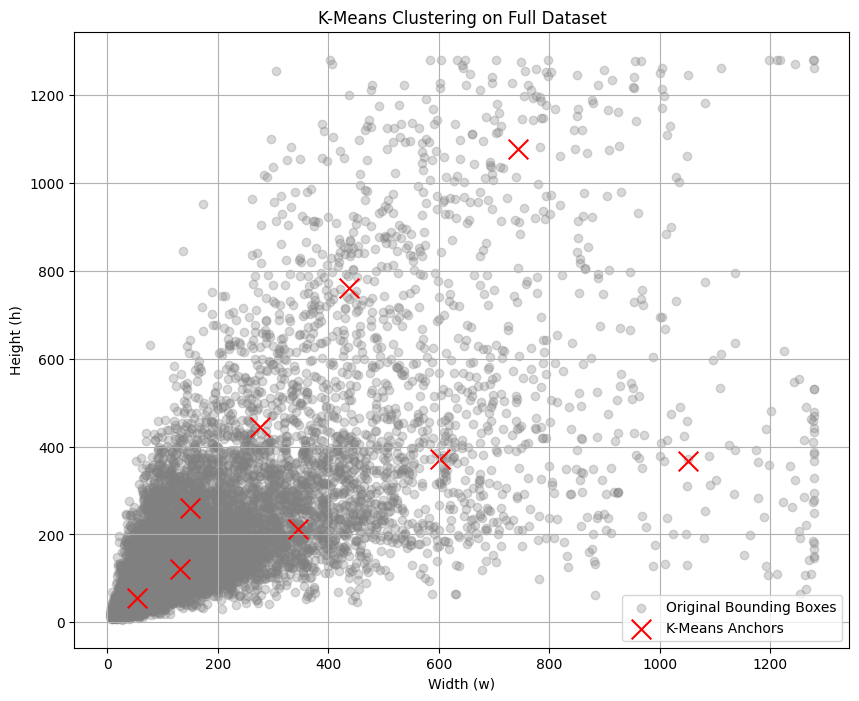


✅ SCALE별로 정렬된 앵커 박스 (w, h):
{'13': [array([438, 761]), array([1051,  366]), array([ 744, 1077])], '26': [array([345, 212]), array([276, 445]), array([603, 372])], '52': [array([53, 56]), array([131, 121]), array([149, 260])]}


In [7]:
# K-Means 클러스터링 실행 (전체 데이터셋 기반)
all_bboxes_wh = []
for item in items:
    for bbox in item['bboxes']:
        all_bboxes_wh.append([bbox['w'], bbox['h']])

bboxes_wh_array = np.array(all_bboxes_wh, dtype=np.float32)

n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=30)
kmeans.fit(bboxes_wh_array)
anchors = kmeans.cluster_centers_

# 앵커 박스 크기를 정수로 변환하고 정렬
anchors = np.round(anchors).astype(int)
anchors = sorted(list(anchors), key=lambda x: x[0] * x[1])

print(f"\n✅ 전체 데이터셋으로 계산된 새로운 K-Means 앵커 박스 (w, h):")
print(anchors)

# 앵커 박스 시각화
plt.figure(figsize=(10, 8))
plt.scatter(bboxes_wh_array[:, 0], bboxes_wh_array[:, 1], c='gray', alpha=0.3, label='Original Bounding Boxes')
plt.scatter(np.array(anchors)[:, 0], np.array(anchors)[:, 1], c='red', marker='x', s=200, label='K-Means Anchors')
plt.title('K-Means Clustering on Full Dataset')
plt.xlabel('Width (w)')
plt.ylabel('Height (h)')
plt.legend()
plt.grid(True)
plt.show()

# SCALE별 앵커 박스 할당
anchors_sorted_by_area = sorted(anchors, key=lambda x: x[0] * x[1])
ANCHORS_SCALED = {
    '13': anchors_sorted_by_area[6:9],
    '26': anchors_sorted_by_area[3:6],
    '52': anchors_sorted_by_area[0:3]
}

print(f"\n✅ SCALE별로 정렬된 앵커 박스 (w, h):")
print(ANCHORS_SCALED)

In [8]:
# K-Means를 통해 도출된 최종 앵커 박스 (w, h)
kmeans_anchors = [
    anchors_sorted_by_area[6:9],
    anchors_sorted_by_area[3:6],
    anchors_sorted_by_area[0:3]
]

# 앵커 박스를 YOLOv3의 스케일에 맞게 정렬 (면적 순)
anchors_sorted_by_area = sorted(anchors, key=lambda x: x[0] * x[1])

INPUT_SIZE = 416
SCALES = [13, 26, 52]
STRIDES = [32, 16, 8]

# 업데이트된 앵커
ANCHORS = [tuple(a) for a in anchors_sorted_by_area]

# 업데이트된 SCALE별 앵커
ANCHORS_SCALED = {
    52: [tuple(a) for a in anchors_sorted_by_area[0:3]],
    26: [tuple(a) for a in anchors_sorted_by_area[3:6]],
    13: [tuple(a) for a in anchors_sorted_by_area[6:9]]
}

print("업데이트된 ANCHORS:")
print(ANCHORS)
print("\n✅ 업데이트된 ANCHORS_SCALED:")
print(ANCHORS_SCALED)

업데이트된 ANCHORS:
[(np.int64(53), np.int64(56)), (np.int64(131), np.int64(121)), (np.int64(149), np.int64(260)), (np.int64(345), np.int64(212)), (np.int64(276), np.int64(445)), (np.int64(603), np.int64(372)), (np.int64(438), np.int64(761)), (np.int64(1051), np.int64(366)), (np.int64(744), np.int64(1077))]

✅ 업데이트된 ANCHORS_SCALED:
{52: [(np.int64(53), np.int64(56)), (np.int64(131), np.int64(121)), (np.int64(149), np.int64(260))], 26: [(np.int64(345), np.int64(212)), (np.int64(276), np.int64(445)), (np.int64(603), np.int64(372))], 13: [(np.int64(438), np.int64(761)), (np.int64(1051), np.int64(366)), (np.int64(744), np.int64(1077))]}




---



In [9]:
# 3) Dataset, DataLoader 정의
def build_targets_yolov3(bboxes, num_classes):
    targets = {}
    for S, stride in zip(SCALES, STRIDES):
        A = 3
        T = np.zeros((S, S, A, 5 + num_classes), np.float32)
        targets[S] = T
    for bb in bboxes:
        x, y, w, h, lab = bb["x"], bb["y"], bb["w"], bb["h"], bb["label"]
        cx, cy = x + w / 2, y + h / 2
        best_S, best_a, best_iou = None, None, -1.0
        for S, stride in zip(SCALES, STRIDES):
            anchors = np.array(ANCHORS_SCALED[S], np.float32)
            inter = np.minimum(w, anchors[:, 0]) * np.minimum(h, anchors[:, 1])
            union = (w * h) + (anchors[:, 0] * anchors[:, 1]) - inter + 1e-9
            ious = inter / union
            a = int(np.argmax(ious))
            if ious[a] > best_iou:
                best_iou = float(ious[a])
                best_S = S
                best_a = a
        S = best_S
        stride = INPUT_SIZE // S
        gx, gy = int(cx // stride), int(cy // stride)
        if not (0 <= gx < S and 0 <= gy < S):
            continue
        tx = (cx / stride) - gx
        ty = (cy / stride) - gy
        aw, ah = ANCHORS_SCALED[S][best_a]
        tw = math.log(max(w, 1e-6) / aw)
        th = math.log(max(h, 1e-6) / ah)
        T = targets[S]
        T[gy, gx, best_a, 0] = tx
        T[gy, gx, best_a, 1] = ty
        T[gy, gx, best_a, 2] = tw
        T[gy, gx, best_a, 3] = th
        T[gy, gx, best_a, 4] = 1.0
        cid = cls2idx.get(lab, -1)
        if cid >= 0:
            T[gy, gx, best_a, 5 + cid] = 1.0
    return targets

def letterbox(im, new_size, color=(114, 114, 114)):
    w, h = im.size
    s = min(new_size / w, new_size / h)
    nw, nh = int(w * s), int(h * s)
    im_r = im.resize((nw, nh), Image.BILINEAR)
    canvas = Image.new('RGB', (new_size, new_size), color)
    pad_x = (new_size - nw) // 2
    pad_y = (new_size - nh) // 2
    canvas.paste(im_r, (pad_x, pad_y))
    return canvas, s, pad_x, pad_y

class DS(Dataset):
    def __init__(self, items, augment=True):
        self.items = items
        self.augment = augment
        self.INPUT_SIZE = globals().get("INPUT_SIZE", 416)
        self.num_classes = globals().get("num_classes", 0)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        im = Image.open(it["img_path"]).convert("RGB")
        bbs = it["bboxes"]

        # 원본 이미지 크기
        w_orig, h_orig = im.size

        if self.augment:
            # 배경과 선 색상 반전 (50% 확률)
            if random.random() < 0.5:
                im = ImageOps.invert(im)

            # 랜덤 미러링 (좌우 반전)
            if random.random() > 0.5:
                im = ImageOps.mirror(im)
                for bb in bbs:
                    bb["x"] = w_orig - bb["x"] - bb["w"]

            # 색상 지터링 (Color Jittering)
            enhancer = ImageEnhance.Brightness(im)
            im = enhancer.enhance(random.uniform(0.8, 1.2))
            enhancer = ImageEnhance.Contrast(im)
            im = enhancer.enhance(random.uniform(0.8, 1.2))
            enhancer = ImageEnhance.Color(im)
            im = enhancer.enhance(random.uniform(0.8, 1.2))
            enhancer = ImageEnhance.Sharpness(im)
            im = enhancer.enhance(random.uniform(0.8, 1.2))

            # 랜덤 블러 (Random Blur)
            if random.random() < 0.2:
                im = im.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

            # 가우시안 노이즈 추가
            if random.random() < 0.3:
                im_np = np.asarray(im)
                # 평균 0, 표준편차 25의 노이즈 추가
                noise = np.random.normal(0, 25, im_np.shape).astype('uint8')
                im_np = im_np + noise
                im_np = np.clip(im_np, 0, 255)
                im = Image.fromarray(im_np)

        im_lb, s, px, py = letterbox(im, self.INPUT_SIZE)

        fixed = []
        for bb in bbs:
            x = bb["x"] * s + px
            y = bb["y"] * s + py
            w = bb["w"] * s
            h = bb["h"] * s
            fixed.append({"x": x, "y": y, "w": w, "h": h, "label": bb["label"]})

        T = build_targets_yolov3(fixed, self.num_classes)
        arr = np.asarray(im_lb, np.float32) / 255.0
        arr = np.transpose(arr, (2, 0, 1))
        img = torch.from_numpy(arr)
        targets = {S: torch.from_numpy(T[S]) for S in SCALES}

        return img, targets

In [10]:
# 4) 모델 정의
def conv_bn_act(c_in, c_out, k=3, s=1, p=None):
    if p is None: p=(k-1)//2
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, s, p, bias=False),
        nn.BatchNorm2d(c_out),
        nn.LeakyReLU(0.1, inplace=True)
    )

class ResBlk(nn.Module):
    def __init__(self, c, dropout_rate=0.5):
        super().__init__();
        self.c1 = conv_bn_act(c, c // 2, 1, 1, 0)
        self.c2 = conv_bn_act(c // 2, c, 3, 1, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        return x + self.dropout(self.c2(self.c1(x)))

class Darknet53_Slim(nn.Module):
    def __init__(self):
        super().__init__()
        self.s = conv_bn_act(3, 16, 3, 1)
        self.d1 = nn.Sequential(conv_bn_act(16, 32, 3, 2), ResBlk(32))
        self.d2 = nn.Sequential(conv_bn_act(32, 64, 3, 2), *[ResBlk(64) for _ in range(2)])
        self.d3 = nn.Sequential(conv_bn_act(64, 128, 3, 2), *[ResBlk(128) for _ in range(8)])
        self.d4 = nn.Sequential(conv_bn_act(128, 256, 3, 2), *[ResBlk(256) for _ in range(8)])
        self.d5 = nn.Sequential(conv_bn_act(256, 512, 3, 2), *[ResBlk(512) for _ in range(4)])
    def forward(self, x):
        x = self.s(x)
        x = self.d1(x)
        x = self.d2(x)
        x52 = self.d3(x)  # 채널 수: 128
        x26 = self.d4(x52) # 채널 수: 256
        x13 = self.d5(x26) # 채널 수: 512
        return x13, x26, x52

def yolo_head(c_in, c_out):
    seq = nn.Sequential(
        conv_bn_act(c_in, c_in, 1, 1, 0),
        conv_bn_act(c_in, c_in * 2, 3, 1, 1),
        conv_bn_act(c_in * 2, c_in, 1, 1, 0),
        conv_bn_act(c_in, c_in * 2, 3, 1, 1),
        conv_bn_act(c_in * 2, c_in, 1, 1, 0)
    )
    pred = nn.Conv2d(c_in, c_out, 1, 1, 0)
    return seq, pred

# Slimmed-down Darknet53에 맞춰 YOLOv3 재구성
class YOLOv3(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C
        self.back = Darknet53_Slim() # 수정된 Darknet53 사용

        # Darknet53_Slim의 출력 채널 수(512, 256, 128)에 맞춰 yolo_head의 c_in을 변경
        # x13의 채널 수: 512
        self.h13, self.p13 = yolo_head(512, 3 * (5 + C))

        # x26의 채널 수: 256
        # h13에서 route26으로 이어지는 채널 수를 512에서 256으로 줄임
        self.red26 = conv_bn_act(512, 256, 1, 1, 0)
        # u26(256) + x26(256) = 512 채널이 h26의 입력이 됨
        self.h26, self.p26 = yolo_head(512, 3 * (5 + C))

        # x52의 채널 수: 128
        # h26에서 route52로 이어지는 채널 수를 512에서 128으로 줄임
        self.red52 = conv_bn_act(512, 128, 1, 1, 0)
        # u52(128) + x52(128) = 256 채널이 h52의 입력이 됨
        self.h52, self.p52 = yolo_head(256, 3 * (5 + C))

        self.up = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x13, x26, x52 = self.back(x)

        # x13에서 YOLO 헤드 계산
        h13 = self.h13(x13)
        p13 = self.p13(h13)

        # x26을 위한 피처맵 업샘플링 및 결합
        route26 = self.red26(h13)
        u26 = self.up(route26)
        h26 = torch.cat([u26, x26], dim=1)
        h26 = self.h26(h26)
        p26 = self.p26(h26)

        # x52를 위한 피처맵 업샘플링 및 결합
        route52 = self.red52(h26)
        u52 = self.up(route52)
        h52 = torch.cat([u52, x52], dim=1)
        h52 = self.h52(h52)
        p52 = self.p52(h52)

        def reshape(p, S):
            N = p.shape[0]
            A = 3
            C = 5 + self.C
            return p.view(N, A, C, S, S).permute(0, 1, 3, 4, 2).contiguous()

        return {13: reshape(p13, 13), 26: reshape(p26, 26), 52: reshape(p52, 52)}

In [11]:
# 손실, 옵티마이저, 스케줄러 정의
class LossV3(nn.Module):
    def __init__(self, C, lambda_noobj=0.1):
        super().__init__(); self.C=C; self.lambda_noobj=lambda_noobj
    def forward(self, preds, tgts):
        tot=0.0; comp={"coord":0.0,"obj":0.0,"noobj":0.0,"cls":0.0}
        for S in [13,26,52]:
            p = preds[S]              # (N,3,S,S,5+C)
            t = tgts[S].permute(0,3,1,2,4).to(p.device)  # (N,3,S,S,5+C)
            obj = t[...,4]==1.0
            no  = t[...,4]==0.0
            if obj.any():
                lxy = F.mse_loss(torch.sigmoid(p[...,0][obj]), t[...,0][obj], reduction='sum') + \
                      F.mse_loss(torch.sigmoid(p[...,1][obj]), t[...,1][obj], reduction='sum')
                lwh = F.mse_loss(p[...,2][obj], t[...,2][obj], reduction='sum') + \
                      F.mse_loss(p[...,3][obj], t[...,3][obj], reduction='sum')
                lobj= F.binary_cross_entropy_with_logits(p[...,4][obj], torch.ones_like(p[...,4][obj]), reduction='sum')
                lcls= F.binary_cross_entropy_with_logits(p[...,5:][obj], t[...,5:][obj], reduction='sum')
            else:
                lxy=lwh=lobj=lcls=torch.tensor(0.0, device=p.device)
            lno = F.binary_cross_entropy_with_logits(p[...,4][no], torch.zeros_like(p[...,4][no]), reduction='sum') if no.any() else torch.tensor(0.0, device=p.device)
            loss = lxy + lwh + lobj + self.lambda_noobj*lno + lcls
            tot = tot + loss
            comp["coord"]+=float((lxy+lwh).item()); comp["obj"]+=float(lobj.item()); comp["noobj"]+=float(lno.item()); comp["cls"]+=float(lcls.item())

        return tot/preds[13].shape[0], comp

In [12]:
# 6) 학습 루프 (K-Fold 적용)
def train_ep(model, opt, criterion, train_loader):
    model.train(); total=0.0
    for x, t in tqdm(train_loader, desc="train"):
        x = x.to(DEVICE).float()
        tt = {S: t[S].to(DEVICE).float() for S in SCALES}
        p = model(x)
        loss, _ = criterion(p, tt)
        opt.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
        total += loss.item()
    return total / len(train_loader)

@torch.no_grad()
def val_ep(model, criterion, val_loader):
    model.eval(); total=0.0
    for x, t in val_loader:
        x = x.to(DEVICE).float(); tt = {S: t[S].to(DEVICE).float() for S in SCALES}
        p = model(x); loss, _ = criterion(p, tt); total += loss.item()
    return total / len(val_loader)

# ✅ K-Fold 교차 검증을 위한 데이터 로딩
from sklearn.model_selection import KFold
import numpy as np
import os
from torch.utils.data import DataLoader

# 전체 데이터셋 로드
train_json_files = sorted(list(train_labels_dir.rglob("*.json")))
val_json_files = sorted(list(valid_labels_dir.rglob("*.json")))

all_items = [parse_json(jp) for jp in train_json_files]
all_items.extend([parse_json(jp) for jp in val_json_files])

# 유효한 이미지 경로가 있는 항목만 필터링
all_items = [item for item in all_items if item["img_path"] is not None and Path(item["img_path"]).exists()]

# KFold 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
CKPT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/yolov3_ckp")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
EPOCHS = 100 # 조기 종료를 위해 충분히 큰 값으로 설정
all_val_losses = []
for i, (train_index, val_index) in enumerate(kf.split(all_items)):
    print(f"================== Fold {i+1}/{n_splits} ==================")
    train_items_fold = [all_items[j] for j in train_index]
    val_items_fold = [all_items[j] for j in val_index]

    train_loader = DataLoader(DS(train_items_fold), batch_size=4, shuffle=True, num_workers=os.cpu_count() // 2, pin_memory=True)
    val_loader = DataLoader(DS(val_items_fold, augment=False), batch_size=4, shuffle=False, num_workers=os.cpu_count() // 2, pin_memory=True)

    print(f"훈련 데이터셋: {len(train_items_fold)}개, 검증 데이터셋: {len(val_items_fold)}개")

    # ✅ 모델, 옵티마이저, 스케줄러를 매 폴드마다 새로 초기화
    model = YOLOv3(len(classes)).to(DEVICE)
    criterion = LossV3(len(classes), lambda_noobj=0.1).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.2, patience=5)

    best_val_loss = float('inf');
    epochs_no_improve = 0;
    patience = 5

    # ✅ 폴드별 가중치 로드: 이어서 학습하기 위한 로직 추가
    checkpoint_path = CKPT_DIR / f"yolov3_best_model_fold_{i+1}.pth"
    start_epoch = 1
    if checkpoint_path.exists():
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        opt.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['val_loss']
        print(f"✅ Fold {i+1}의 최적 가중치 파일을 로드하여 {start_epoch-1} 에포크에서 학습을 재개합니다.")
    else:
        print(f"⚠️ Fold {i+1}의 가중치 파일을 찾을 수 없습니다. 처음부터 학습을 시작합니다.")

    for ep in range(start_epoch, EPOCHS + 1):
        tl = train_ep(model, opt, criterion, train_loader)
        vl = val_ep(model, criterion, val_loader)
        scheduler.step(vl)
        print(f"[{ep:02d}] train={tl:.3f} val={vl:.3f}")

        if vl < best_val_loss:
            best_val_loss = vl
            epochs_no_improve = 0
            torch.save({
                'epoch': ep,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'val_loss': vl
            }, checkpoint_path)
            print(f"✅ Fold {i+1}의 최적 모델이 {ep} 에포크에서 개선되어 저장되었습니다.")
        else:
            epochs_no_improve += 1
            print(f"⚠️ {epochs_no_improve} 에포크 동안 개선이 없습니다.")

        if epochs_no_improve >= patience:
            print(f"⏳ Fold {i+1} 조기 종료: {patience} 에포크 동안 검증 손실 개선이 없어 학습을 중단합니다.")
            break

    all_val_losses.append(best_val_loss)

print("============================================")
print("✅ K-Fold 교차 검증 완료!")
print(f"각 폴드별 최적 검증 손실: {all_val_losses}")
print(f"평균 검증 손실: {np.mean(all_val_losses):.3f}")

================== Fold 1/5 ==================
훈련 데이터셋: 448개, 검증 데이터셋: 112개
✅ Fold 1의 최적 가중치 파일을 로드하여 84 에포크에서 학습을 재개합니다.


train: 100%|██████████| 112/112 [00:18<00:00,  6.05it/s]


[85] train=45.775 val=35.471
✅ Fold 1의 최적 모델이 85 에포크에서 개선되어 저장되었습니다.


train: 100%|██████████| 112/112 [00:16<00:00,  6.60it/s]


[86] train=46.322 val=37.670
⚠️ 1 에포크 동안 개선이 없습니다.


train:  24%|██▍       | 27/112 [00:05<00:16,  5.02it/s]


KeyboardInterrupt: 

In [14]:
# 폰트 설치
!sudo apt-get install -y fonts-nanum-extra
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 라이브러리 임포트 및 한글 폰트 설정
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

# 폰트 경로 설정 (Colab 기본 나눔 폰트)
try:
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf"
    k_font = ImageFont.truetype(font_path, 20)
    print("✅ 나눔 폰트가 성공적으로 로드되었습니다.")
except IOError:
    print("⚠️ 폰트 파일을 찾을 수 없습니다. 기본 폰트를 사용합니다.")
    k_font = ImageFont.load_default()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-nanum
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-extra
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 31.4 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0 MB]
Fetched 31.4 MB in 4s (7,920 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.

In [23]:
def decode_yolo(preds, anchors, S, input_size, C):
    N = preds.shape[0]
    A = len(anchors)
    preds[..., 0:2] = torch.sigmoid(preds[..., 0:2])
    preds[..., 4] = torch.sigmoid(preds[..., 4])
    preds[..., 5:] = torch.sigmoid(preds[..., 5:])
    grid_y, grid_x = torch.meshgrid(torch.arange(S), torch.arange(S), indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=2).view((1, 1, S, S, 2)).to(preds.device)
    anchor_wh = torch.tensor(anchors, dtype=torch.float32).view((1, A, 1, 1, 2)).to(preds.device)
    stride = input_size / S
    preds[..., 0:2] = (preds[..., 0:2] + grid) * stride
    preds[..., 2:4] = torch.exp(preds[..., 2:4]) * anchor_wh
    preds[..., 0] = preds[..., 0] - preds[..., 2] / 2
    preds[..., 1] = preds[..., 1] - preds[..., 3] / 2
    preds[..., 2] = preds[..., 0] + preds[..., 2]
    preds[..., 3] = preds[..., 1] + preds[..., 3]
    return preds.view(N, -1, 5 + C)

def non_max_suppression(bboxes, iou_thresh=0.3, conf_thresh=0.4):
    """
    Non-Maximum Suppression (NMS) 적용
    - bboxes 리스트를 직접 업데이트하여 IndexError를 방지합니다.
    """
    if bboxes.shape[0] == 0:
        return []

    # 신뢰도 임계값으로 필터링
    bboxes = bboxes[bboxes[:, 4] > conf_thresh]
    if bboxes.shape[0] == 0:
        return []

    # 신뢰도 점수 기준으로 내림차순 정렬
    bboxes = bboxes[bboxes[:, 4].argsort(descending=True)]

    selected_boxes = []
    while len(bboxes) > 0:
        # 가장 높은 점수를 가진 바운딩 박스를 선택 (정렬되었으므로 첫 번째 박스)
        current_bbox = bboxes[0]
        selected_boxes.append(current_bbox)

        # 선택된 박스와 나머지 박스들의 IoU 계산
        x1 = bboxes[:, 0]
        y1 = bboxes[:, 1]
        x2 = bboxes[:, 2]
        y2 = bboxes[:, 3]

        area_current = (current_bbox[2] - current_bbox[0]) * (current_bbox[3] - current_bbox[1])
        area_others = (x2 - x1) * (y2 - y1)

        inter_x1 = torch.max(current_bbox[0], x1)
        inter_y1 = torch.max(current_bbox[1], y1)
        inter_x2 = torch.min(current_bbox[2], x2)
        inter_y2 = torch.min(current_bbox[3], y2)

        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)
        union_area = area_current + area_others - inter_area
        # 작은 값으로 나누는 것을 방지
        ious = inter_area / (union_area + 1e-6)

        # IoU가 임계값보다 낮은 박스만 남김
        mask = ious <= iou_thresh
        bboxes = bboxes[mask]

    return selected_boxes

def predict_image(model, image_path, classes, confidence_thresh=0.4, iou_thresh=0.3):
    model.eval()
    im = Image.open(image_path).convert("RGB")
    original_size = im.size
    im_lb, s, px, py = letterbox(im, INPUT_SIZE)
    img_tensor = torch.from_numpy(np.asarray(im_lb, dtype=np.float32) / 255.0).permute(2, 0, 1).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        preds = model(img_tensor)

    all_bboxes = []
    for S, anchors in ANCHORS_SCALED.items():
        all_bboxes.append(decode_yolo(preds[S], anchors, S, INPUT_SIZE, len(classes)))

    all_bboxes = torch.cat(all_bboxes, dim=1).squeeze(0)

    final_bboxes = non_max_suppression(all_bboxes, iou_thresh=iou_thresh, conf_thresh=confidence_thresh)

    results = []
    for bbox in final_bboxes:
        bbox_raw = bbox.cpu().numpy()
        x1, y1, x2, y2, conf = bbox_raw[0:5]
        class_idx = np.argmax(bbox_raw[5:])

        x1 = (x1 - px) / s
        y1 = (y1 - py) / s
        x2 = (x2 - px) / s
        y2 = (y2 - py) / s

        results.append({
            'box': (x1, y1, x2, y2),
            'confidence': conf,
            'class': classes[class_idx]
        })
    return im, results

def draw_bboxes_on_image(image, bboxes, font):
    """
    이미지 위에 초록색 얇은 바운딩 박스와 라벨, 배경을 시각화합니다.
    """
    draw = ImageDraw.Draw(image)
    W, H = image.size
    # ⚠️ 수정된 부분: 두께를 얇게 조정
    thick = max(1, int(max(W, H) / 512 * 1)); pad = 3

    for p in bboxes:
        box = p['box']
        cls_score = p['confidence']
        cls_name = p['class']

        x1, y1, x2, y2 = box

        # ✅ 바운딩 박스 색상을 초록색으로 고정
        box_outline_color = (0, 255, 0) # 초록색

        draw.rectangle([x1, y1, x2, y2], outline=(0, 0, 0), width=thick + 1)
        draw.rectangle([x1, y1, x2, y2], outline=box_outline_color, width=thick)

        # ✅ 라벨 텍스트와 배경 그리기
        text = f"{cls_name} {cls_score:.2f}"

        text_bbox = draw.textbbox((x1, y1), text, font=font)
        tw = text_bbox[2] - text_bbox[0]
        th = text_bbox[3] - text_bbox[1]

        bx1 = max(0, x1); by1 = y1 - th - 2*pad
        if by1 < 0: by1 = y1
        bx2 = min(W, bx1 + tw + 2*pad); by2 = min(H, by1 + th + 2*pad)
        draw.rectangle([bx1, by1, bx2, by2], fill=(255, 255, 255))
        draw.rectangle([bx1, by1, bx2, by2], outline=(0, 0, 0), width=1)
        draw.text((bx1 + pad, by1 + pad), text, fill=(0, 0, 0), font=font)

    return image

def crop_and_save_objects(image_path, bboxes, output_dir="cropped_objects"):
    """
    YOLOv3 모델의 예측 결과를 기반으로 객체를 크롭하고 저장합니다.
    """
    os.makedirs(output_dir, exist_ok=True)
    original_image = Image.open(image_path).convert("RGB")

    print(f"이미지 '{os.path.basename(image_path)}'에서 객체들을 크롭하여 저장합니다...")
    for i, bbox in enumerate(bboxes):
        box = bbox['box']
        class_label = bbox['class']
        confidence = bbox['confidence']

        x1, y1, x2, y2 = [int(v) for v in box]
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(original_image.width, x2)
        y2 = min(original_image.height, y2)

        if x2 > x1 and y2 > y1:
            cropped_img = original_image.crop((x1, y1, x2, y2))
            filename = f"{class_label}_{confidence:.2f}_{i}.jpg"
            save_path = os.path.join(output_dir, filename)
            cropped_img.save(save_path)
            print(f"✅ 객체 {i+1} 저장 완료: {save_path}")
    print("객체 크롭 및 저장이 모두 완료되었습니다.\n")

✅ Fold 1의 최적 모델 가중치가 로드되었습니다.

✅ 이미지: 나무_13_여_06046.jpg
✅ 감지된 객체 수: 28개


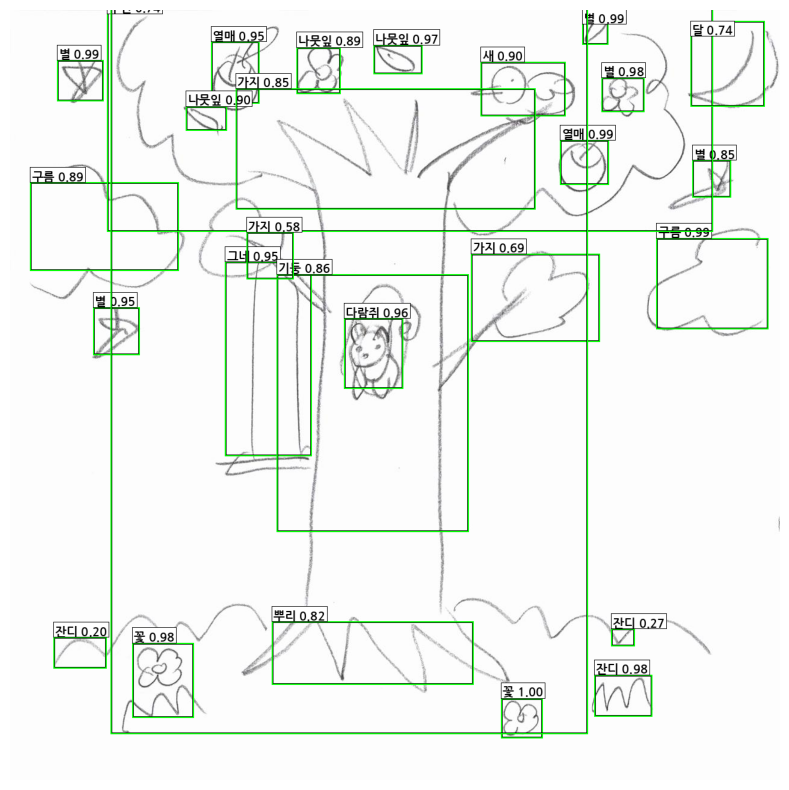

In [25]:
# 수정된 추론 및 시각화 실행 코드
# =======================================================
from sklearn.model_selection import KFold
import numpy as np
import os
from torch.utils.data import DataLoader

# 데이터셋 로드
train_json_files = sorted(list(train_labels_dir.rglob("*.json")))
val_json_files = sorted(list(valid_labels_dir.rglob("*.json")))
all_items = [parse_json(jp) for jp in train_json_files]
all_items.extend([parse_json(jp) for jp in val_json_files])
all_items = [item for item in all_items if item["img_path"] is not None and Path(item["img_path"]).exists()]

# KFold 설정
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
CKPT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/yolov3_ckp")

# 수정된 부분: kf.split을 한 번만 실행하고, 인덱스를 직접 사용
split_indices = list(kf.split(all_items))
fold_idx = 0
train_index, val_index = split_indices[fold_idx]

# 모델 인스턴스 생성 및 가중치 로드
model = YOLOv3(len(classes)).to(DEVICE)
checkpoint_path = CKPT_DIR / f"yolov3_best_model_fold_{fold_idx+1}.pth"

# ⚠️ 오류 방지를 위해, 파일이 존재할 경우에만 로드
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Fold {fold_idx+1}의 최적 모델 가중치가 로드되었습니다.")
else:
    print(f"⚠️ Fold {fold_idx+1}의 최적 가중치 파일이 존재하지 않아 추론을 건너뜁니다.")
    exit()

# 검증 데이터셋에서 이미지 선택
sample_item = all_items[val_index[23]]
sample_image_path = sample_item['img_path']

# 추론 및 시각화 (confidence_thresh를 0.2로 낮춤)
original_image, detected_bboxes = predict_image(model, sample_image_path, classes, confidence_thresh=0.2)
visualized_image = draw_bboxes_on_image(original_image, detected_bboxes, k_font)

print(f"\n✅ 이미지: {os.path.basename(sample_image_path)}")
print(f"✅ 감지된 객체 수: {len(detected_bboxes)}개")

plt.figure(figsize=(15, 10)) # 가로 15인치, 세로 10인치 크기로 설정
plt.imshow(visualized_image)
plt.axis('off')
plt.show()

In [26]:
def export_classifier_crops_from_gt(items, out_dir="cls_crops_yolo", min_size=8):
    """
    원본 JSON 파일(Ground Truth)의 바운딩 박스를 기준으로 객체를 크롭하고 저장합니다.
    - out_dir: ImageFolder 구조로 저장 (label/xxx.jpg)
    """
    out = Path(out_dir)
    if out.exists():
        shutil.rmtree(out)
    out.mkdir(parents=True, exist_ok=True)

    n_ok = 0
    for it in items:
        img_path = it["img_path"]
        im = Image.open(img_path).convert("RGB")
        W, H = im.size
        for i, bb in enumerate(it["bboxes"]):
            x, y, w, h = float(bb["x"]), float(bb["y"]), float(bb["w"]), float(bb["h"])
            if w < min_size or h < min_size:
                continue
            x1, y1 = int(max(0, x)), int(max(0, y))
            x2, y2 = int(min(W, x + w)), int(min(H, y + h))
            if x2 <= x1 or y2 <= y1:
                continue
            crop = im.crop((x1, y1, x2, y2))
            cls_name = str(bb.get("label", "unknown"))
            cls_dir = out / cls_name
            cls_dir.mkdir(parents=True, exist_ok=True)
            save_name = f"{Path(img_path).stem}_{i}.jpg"
            crop.save(cls_dir / save_name, quality=95)
            n_ok += 1
    print(f"[OK] saved {n_ok} crops to {out.resolve()}")
    return out.resolve()

# kf.split을 한 번만 실행하고, 인덱스를 직접 사용
split_indices = list(kf.split(all_items))
fold_idx = 0
train_index, val_index = split_indices[fold_idx]

# ✅ 학습 데이터셋과 검증 데이터셋 준비
train_items = [all_items[j] for j in train_index]
val_items = [all_items[j] for j in val_index]

# ✅ 학습용 크롭 이미지 생성
print("--- 훈련 데이터셋 크롭 이미지 생성 시작 ---")
train_crops_dir = export_classifier_crops_from_gt(train_items, "cls_crops_yolo_train")

# ✅ 검증용 크롭 이미지 생성
print("\n--- 검증 데이터셋 크롭 이미지 생성 시작 ---")
val_crops_dir = export_classifier_crops_from_gt(val_items, "cls_crops_yolo_val")

print("\n✅ 모든 데이터셋의 크롭 이미지 생성이 완료되었습니다.")

--- 훈련 데이터셋 크롭 이미지 생성 시작 ---
[OK] saved 11099 crops to /content/cls_crops_yolo_train

--- 검증 데이터셋 크롭 이미지 생성 시작 ---
[OK] saved 2706 crops to /content/cls_crops_yolo_val

✅ 모든 데이터셋의 크롭 이미지 생성이 완료되었습니다.


In [27]:
import torch
import torchvision
from torchvision import transforms
# 전역 변수 설정 (이전에 정의된 변수 사용)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

# 훈련 데이터셋 전처리: 리사이즈, 랜덤 크롭, 랜덤 플립, 정규화
tf_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 검증 데이터셋 전처리: 리사이즈, 센터 크롭, 정규화
tf_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 크롭 이미지가 저장된 폴더 경로
train_crops_dir = Path("cls_crops_yolo_train")
val_crops_dir   = Path("cls_crops_yolo_val")

# `ImageFolder`를 사용하여 데이터셋 생성
ds_train = torchvision.datasets.ImageFolder(train_crops_dir, tf_train)
ds_val   = torchvision.datasets.ImageFolder(val_crops_dir,   tf_val)

# 클래스 정보 추출
num_classes_cls = len(ds_train.classes)
cls_idx2name = {i:n for i,n in enumerate(ds_train.classes)}
print(f"분류 모델 클래스 수: {num_classes_cls}")
print(f"클래스 이름: {ds_train.classes}")

# DataLoader 생성
dl_train = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# 2. ResNet18 모델 및 학습 설정

def build_resnet18(num_classes):
    try:
        # ImageNet 사전 학습 가중치 사용
        m = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
    except Exception:
        # 가중치 로드 실패 시 None 사용
        m = torchvision.models.resnet18(weights=None)

    # ⚠️ 모든 파라미터 학습 허용 (고정 로직 제거)
    in_f = m.fc.in_features
    # ✅ 마지막 Fully Connected 레이어를 클래스 수에 맞게 수정
    m.fc = nn.Linear(in_f, num_classes)

    return m

# 모델, 옵티마이저, 손실 함수 정의
cls_model = build_resnet18(num_classes_cls).to(DEVICE)
# ⚠️ 수정된 부분: 학습률 1e-3, weight_decay 1e-4로 복원
opt = torch.optim.Adam(cls_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion_ce = nn.CrossEntropyLoss()

# 3. 학습 및 검증 루프
def train_cls_ep():
    cls_model.train(); total=0.0; correct=0; n=0
    for x,y in dl_train:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = cls_model(x)
        loss = criterion_ce(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*y.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); n += y.size(0)
    return total/n, correct/n

@torch.no_grad()
def val_cls_ep():
    cls_model.eval(); total=0.0; correct=0; n=0
    for x,y in dl_val:
        x,y = x.to(DEVICE), y.to(DEVICE)
        logits = cls_model(x)
        loss = criterion_ce(logits, y)
        total += loss.item()*y.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item(); n += y.size(0)
    return total/n, correct/n

# 4. 학습 시작
EPOCHS = 20
best = 0.0

# ✅ 추가된 부분: 가중치 파일 로드
checkpoint_path = "cls_resnet18_best.pt"
start_epoch = 1

if os.path.exists(checkpoint_path):
    print(f"✅ 최적 가중치 파일을 로드하여 학습을 재개합니다.")
    checkpoint = torch.load(checkpoint_path)
    cls_model.load_state_dict(checkpoint['model'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    best = checkpoint.get('best_acc', 0.0)

    print(f"이어서 학습을 재개합니다 (시작 에포크: {start_epoch}, 최적 정확도: {best:.3f})")
else:
    print(f"⚠️ 가중치 파일을 찾을 수 없습니다. 처음부터 학습을 시작합니다.")

for ep in range(start_epoch, EPOCHS+1):
    tl, ta = train_cls_ep()
    vl, va = val_cls_ep()
    print(f"[{ep:02d}] train loss {tl:.3f} acc {ta:.3f} | val loss {vl:.3f} acc {va:.3f}")
    if va > best:
        best = va
        # 최적 모델 가중치 저장
        torch.save({"model": cls_model.state_dict(), "classes": ds_train.classes, "epoch": ep, "best_acc": best}, checkpoint_path)
        print("   ↳ best classifier saved")

분류 모델 클래스 수: 47
클래스 이름: ['가지', '구름', '굴뚝', '귀', '그네', '기둥', '길', '꽃', '나무', '나무전체', '나뭇잎', '남자구두', '눈', '다람쥐', '다리', '단추', '달', '머리', '머리카락', '목', '문', '발', '별', '뿌리', '사람전체', '산', '상체', '새', '손', '수관', '얼굴', '여자구두', '연기', '연못', '열매', '운동화', '울타리', '입', '잔디', '주머니', '지붕', '집벽', '집전체', '창문', '코', '태양', '팔']
✅ 최적 가중치 파일을 로드하여 학습을 재개합니다.
이어서 학습을 재개합니다 (시작 에포크: 4, 최적 정확도: 0.561)
[04] train loss 0.931 acc 0.712 | val loss 1.599 acc 0.541
[05] train loss 0.826 acc 0.741 | val loss 1.399 acc 0.610
   ↳ best classifier saved
[06] train loss 0.751 acc 0.767 | val loss 1.362 acc 0.601
[07] train loss 0.692 acc 0.778 | val loss 1.356 acc 0.636
   ↳ best classifier saved
[08] train loss 0.669 acc 0.788 | val loss 1.860 acc 0.533
[09] train loss 0.604 acc 0.805 | val loss 1.372 acc 0.634
[10] train loss 0.588 acc 0.805 | val loss 1.245 acc 0.656
   ↳ best classifier saved
[11] train loss 0.550 acc 0.822 | val loss 1.393 acc 0.624
[12] train loss 0.536 acc 0.826 | val loss 1.475 acc 0.615
[13] train

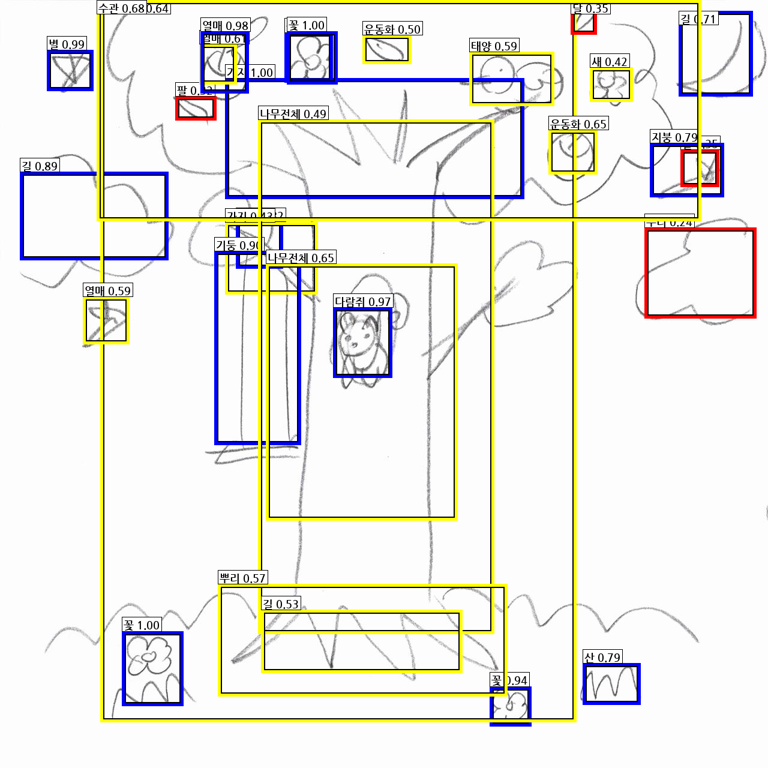

In [28]:
# 폰트, 전처리, 헬퍼 함수 정의
def _get_font(size=18):
    paths = [
        "/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.ttc",
        "/usr/share/fonts/truetype/noto/NotoSansCJK-Regular.otf",
        "/Library/Fonts/AppleGothic.ttf",
        "C:/Windows/Fonts/malgun.ttf",
    ]
    for p in paths:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            pass
    return ImageFont.load_default()

def de_letterbox_xyxy(x1, y1, x2, y2, scale, pad_x, pad_y):
    ox1 = (x1 - pad_x) / scale
    oy1 = (y1 - pad_y) / scale
    ox2 = (x2 - pad_x) / scale
    oy2 = (y2 - pad_y) / scale
    return ox1, oy1, ox2, oy2

def letterbox(im, new_size, color=(114, 114, 114)):
    w, h = im.size
    s = min(new_size / w, new_size / h)
    nw, nh = int(w * s), int(h * s)
    im_r = im.resize((nw, nh), Image.BILINEAR)
    canvas = Image.new('RGB', (new_size, new_size), color)
    pad_x = (new_size - nw) // 2
    pad_y = (new_size - nh) // 2
    canvas.paste(im_r, (pad_x, pad_y))
    return canvas, s, pad_x, pad_y

def nms_np(boxes, scores, iou_thresh):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        union = areas[i] + areas[order[1:]] - inter
        iou = inter / union
        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]
    return keep

# ResNet18 전처리
tf_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# 2. YOLOv3 탐지 후 ResNet18 분류 함수
@torch.no_grad()
def infer_image(img_path, conf_th=0.15, iou_th=0.45):
    im = Image.open(img_path).convert("RGB")
    im_lb, s, px, py = letterbox(im, INPUT_SIZE)
    arr = np.transpose(np.asarray(im_lb, np.float32) / 255.0, (2, 0, 1))
    t = torch.from_numpy(arr).unsqueeze(0).to(DEVICE)
    out = model(t)
    boxes_all, scores_all, labels_all = [], [], []

    for S in [13, 26, 52]:
        pred = out[S][0].cpu().numpy()
        stride = INPUT_SIZE // S
        anchors = np.array(ANCHORS_SCALED[S], np.float32)
        for a in range(3):
            for gy in range(S):
                for gx in range(S):
                    tx, ty, tw, th, to = pred[a, gy, gx, :5]
                    obj = 1 / (1 + np.exp(-to))
                    cls_logits = pred[a, gy, gx, 5:]
                    if cls_logits.size > 0:
                        cls_prob = 1 / (1 + np.exp(-cls_logits))
                        cidx = int(np.argmax(cls_prob))
                        conf = obj * cls_prob[cidx]
                    else:
                        conf = obj
                    if conf < conf_th:
                        continue
                    cx = (1 / (1 + np.exp(-tx)) + gx) * stride
                    cy = (1 / (1 + np.exp(-ty)) + gy) * stride
                    bw = anchors[a, 0] * np.exp(tw)
                    bh = anchors[a, 1] * np.exp(th)
                    x1, y1, x2, y2 = cx - bw / 2, cy - bh / 2, cx + bw / 2, cy + bh / 2
                    boxes_all.append([x1, y1, x2, y2])
                    scores_all.append(float(conf))
                    labels_all.append(cidx)

    if len(boxes_all) == 0:
        return im_lb, ([], [], [])
    boxes_all = np.array(boxes_all, np.float32)
    scores_all = np.array(scores_all, np.float32)
    labels_all = np.array(labels_all, np.int32)

    final_boxes, final_scores, final_labels = [], [], []
    for c in np.unique(labels_all):
        idxs = np.where(labels_all == c)[0]
        keep = nms_np(boxes_all[idxs], scores_all[idxs], iou_th)
        for k in keep:
            final_boxes.append(boxes_all[idxs][k].tolist())
            final_scores.append(float(scores_all[idxs][k]))
            final_labels.append(int(c))

    return im_lb, (final_boxes, final_scores, final_labels)


@torch.no_grad()
def detect_then_classify(img_path, conf_th=0.5, iou_th=0.45):
    # 1) letterbox 파라미터 계산
    im = Image.open(img_path).convert("RGB")
    _, scale, pad_x, pad_y = letterbox(im, INPUT_SIZE)

    # 2) YOLO 추론 호출
    drawn, detection_results = infer_image(img_path, conf_th=conf_th, iou_th=iou_th)
    lb_boxes, lb_scores, lb_labels = detection_results

    preds = []
    for (x1, y1, x2, y2), s, yolo_c in zip(lb_boxes, lb_scores, lb_labels):
        # 3) 원본 좌표로 역보정
        ox1, oy1, ox2, oy2 = de_letterbox_xyxy(x1, y1, x2, y2, scale, pad_x, pad_y)
        ox1, oy1 = int(max(0, ox1)), int(max(0, oy1))
        ox2, oy2 = int(min(im.width, ox2)), int(min(im.height, oy2))
        if ox2 <= ox1 or oy2 <= oy1:
            continue
        crop = im.crop((ox1, oy1, ox2, oy2))

        # 4) 분류 모델로 재분류
        x = tf_val(crop).unsqueeze(0).to(DEVICE)
        logits = cls_model(x)
        prob = F.softmax(logits, dim=1)[0]
        cid = int(prob.argmax().item())
        cname = cls_idx2name[cid]
        cscore = float(prob.max().item())

        preds.append({
            "box_orig": [ox1, oy1, ox2, oy2],
            "det_conf": float(s),
            "det_yolo_class": yolo_c,
            "cls_name": cname,
            "cls_score": cscore,
        })

    # 5) 최종 시각화
    draw = im.copy()
    dr = ImageDraw.Draw(draw)
    font = _get_font(18)
    W, H = draw.size
    thick = max(2, int(max(W, H) / 512 * 2)); pad = 3

    for p in preds:
        x1, y1, x2, y2 = p["box_orig"]

        # ⚠️ 수정된 부분: 신뢰도 점수에 따라 바운딩 박스 색상 설정
        if p['cls_score'] >= 0.7:
            box_outline_color = (0, 0, 255) # 파란색
        elif p['cls_score'] >= 0.4:
            box_outline_color = (255, 255, 0) # 노란색
        else:
            box_outline_color = (255, 0, 0) # 빨간색

        dr.rectangle([x1, y1, x2, y2], outline=(0, 0, 0), width=thick + 2)
        dr.rectangle([x1, y1, x2, y2], outline=box_outline_color, width=thick)

        text = f"{p['cls_name']} {p['cls_score']:.2f}"

        text_bbox = dr.textbbox((x1, y1), text, font=font)
        tw = text_bbox[2] - text_bbox[0]
        th = text_bbox[3] - text_bbox[1]

        bx1 = max(0, x1); by1 = y1 - th - 2*pad
        if by1 < 0: by1 = y1
        bx2 = min(W, bx1 + tw + 2*pad); by2 = min(H, by1 + th + 2*pad)
        dr.rectangle([bx1, by1, bx2, by2], fill=(255, 255, 255))
        dr.rectangle([bx1, by1, bx2, by2], outline=(0, 0, 0), width=1)
        dr.text((bx1 + pad, by1 + pad), text, fill=(0, 0, 0), font=font)

    return preds, draw

# === 한 장 테스트 ===
sample_item = all_items[val_index[23]]
sample_image_path = sample_item['img_path']

preds, vis = detect_then_classify(sample_image_path, conf_th=0.35, iou_th=0.45)
display(vis.resize((768, 768)))

In [42]:
def visualize_specific_classification_report(preds, gt_data, classes):
    """
    YOLOv3의 탐지 결과와 실제 GT 라벨을 비교하여
    실제 이미지에 존재하는 클래스에 대한 분류 성능 지표를 출력합니다.
    """
    if not preds:
        print("❌ 분석할 데이터가 부족합니다. 모델이 객체를 탐지하지 못했거나, 임계값보다 낮은 점수를 받았습니다.")
        return

    # 클래스 이름과 인덱스 매핑
    cls_name_to_idx = {name: i for i, name in enumerate(classes)}

    # 이미지의 실제 라벨 (Ground Truth) 추출
    true_labels_from_preds = [p['det_yolo_class'] for p in preds]
    predicted_labels = [cls_name_to_idx.get(p['cls_name']) for p in preds]

    # 리포트 생성
    report = classification_report(
        true_labels_from_preds,
        predicted_labels,
        labels=list(cls_name_to_idx.values()),
        target_names=classes,
        output_dict=True,
        zero_division=0
    )

    report_df = pd.DataFrame(report).transpose()

    # support가 0인 클래스(이미지에 없는 클래스)는 제외
    filtered_report_df = report_df[report_df['support'] > 0]

    print("✅ 실제 이미지에 존재하는 클래스에 대한 Classification Report:")
    print(filtered_report_df[['f1-score', 'support']].to_markdown(floatfmt=".2f"))

visualize_specific_classification_report(preds, all_items, classes)

✅ 실제 이미지에 존재하는 클래스에 대한 Classification Report:
|              |   f1-score |   support |
|:-------------|-----------:|----------:|
| 가지         |       1.00 |      3.00 |
| 구름         |       0.00 |      2.00 |
| 그네         |       0.00 |      1.00 |
| 기둥         |       0.00 |      2.00 |
| 꽃           |       0.86 |      3.00 |
| 나무전체     |       0.50 |      1.00 |
| 나뭇잎       |       0.00 |      4.00 |
| 다람쥐       |       1.00 |      1.00 |
| 달           |       0.00 |      1.00 |
| 별           |       0.29 |      6.00 |
| 뿌리         |       0.50 |      2.00 |
| 새           |       0.00 |      1.00 |
| 수관         |       1.00 |      1.00 |
| 열매         |       0.40 |      2.00 |
| 잔디         |       0.00 |      1.00 |
| accuracy     |       0.39 |      0.39 |
| macro avg    |       0.12 |     31.00 |
| weighted avg |       0.37 |     31.00 |
